In [1]:
import os
import itertools
import uuid
import json
from typing import Callable
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from src.entities import Point
from src.algorithms import Evolution
from src.graph_utils import *
from src.plotting_utils import plot_population
from src.config import DATA_PATH

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np

import benchmark_functions as bf

In [2]:
PARAMS_SETS = {
    'pop_size': [10, 50, 100, 150, 200],
    'iter_num': [100, 200, 500, 1000, 2000],
    'dim': [2, 5, 10, 50, 100],
    # 'target': [bf.Ackley, bf.Rastrigin, bf.Rosenbrock, bf.Schwefel, bf.Hypersphere],
    'target': [bf.Hypersphere],
    # 'mutation_rate': [0.01, 0.1, 0.2, 0.5, 0.8, 1.0],
    'mutation_rate': [1.0],
    'mutation_std_dev': [0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'elitist': [True, False]
}

In [3]:
def run_experiment(
    experiment_id: str, 
    pop_size: int, 
    iter_num: int, 
    dim: int,
    target: Callable, 
    mutation_rate: float,
    mutation_std_dev: float,
    elitist: bool,
    start_population: List[Point] = None,
    save_data=True
):
    target_fun = target(n_dimensions=dim)
    if not start_population:
        start_population = [
            Point(coordinates=np.random.random(size=dim) * 10, target_fun=target_fun)
            for _ in range(pop_size)
        ]

    def mutation_fun(coords: np.array, population_coords: np.array):
        mean = 0.0
        # std_dev = np.std(population_coords)
        std_dev=mutation_std_dev
        gaussian_noise = np.random.normal(mean, std_dev, size=coords.shape)
        return coords + mutation_rate * gaussian_noise

    ev = Evolution(
        population=start_population, 
        mutate_fun=mutation_fun,
        elitist=elitist
    )
    ev.run(iter_num)
    fitness = np.array([p.fitness for p in ev.population])
    
    graph_trimmed = create_graph_from_last_population(ev.population)

    graph_full = create_graph_from_population_log(ev.population_log)
    
    final_population_df = ev.population_to_df()
    
    population_log_df = ev.population_log_to_df()
    
    result = {
        'fitness_mean': np.mean(fitness),
        'fitness_min': np.min(fitness),
        'fitness_std': np.std(fitness),
        'global_min': target_fun.minima()[0].score,
        'global_min_coords': target_fun.minima()[0].position,
        'target_fun': target_fun._name    
    } 
    result = result | {k: v for k,v in locals().items() if type(v) in [bool, str, int, float]}

    if save_data:
        
        if not os.path.exists(f'{DATA_PATH}csv'):
            os.makedirs(f'{DATA_PATH}csv')
        if not os.path.exists(f'{DATA_PATH}json'):
            os.makedirs(f'{DATA_PATH}json')
        if not os.path.exists(f'{DATA_PATH}pickle'):
            os.makedirs(f'{DATA_PATH}pickle')
            
        graph_trimmed_path = f'{experiment_id}_small.pkl'
        graph_full_path = f'{experiment_id}_full.pkl'
        final_population_path = f'{DATA_PATH}csv/{experiment_id}_population.csv'
        log_path = f'{DATA_PATH}csv/{experiment_id}_log.csv'
        
        graph_to_pickle(graph_trimmed, graph_trimmed_path)
        graph_to_pickle(graph_full, graph_full_path)
        final_population_df.to_csv(final_population_path, index=False)
        population_log_df.to_csv(log_path, index=False)

        result = result | {
            'final_population_csv_path': final_population_path,
            'population_log_csv_path': log_path,
            'graph_trimmed_path': graph_trimmed_path,
            'graph_full_path': graph_full_path,
        }
        
        with open(f'{DATA_PATH}json/{experiment_id}.json', 'w') as f:
            json.dump(result, f)

    return ev, result

In [4]:
for params in tqdm(list(itertools.product(*PARAMS_SETS.values()))):
    for _ in range(5):
        try:
            params_dict = dict(zip(PARAMS_SETS.keys(),params))
            experiment_id = str(uuid.uuid4())

            target_fun = params_dict['target'](n_dimensions=params_dict['dim'])
            start_population = [
                Point(coordinates=np.random.normal(size=params_dict['dim'], loc=1000.0, scale=100.0), target_fun=target_fun)
                for _ in range(params_dict['pop_size'])
            ]
            
            run_experiment(experiment_id, start_population=start_population, **params_dict)
        except (ValueError, TypeError, ZeroDivisionError) as e:
            print(f'ERROR {e} : ', params)

 15%|███████████▉                                                                 | 270/1750 [2:26:03<13:20:39, 32.46s/it]


KeyboardInterrupt: 

In [12]:
target_fun = bf.Hypersphere(n_dimensions=2)

start_population = [
    Point(coordinates=np.random.normal(size=2, loc=1000.0, scale=100.0), target_fun=target_fun)
    for _ in range(15)
]

In [21]:
ev, res = run_experiment(
    experiment_id = 'test', 
    pop_size = 15, 
    iter_num = 20, 
    dim = 2,
    target = bf.Hypersphere, 
    mutation_rate = 1.0,
    mutation_std_dev=10.0,
    elitist = False,
    save_data = False,
    start_population=start_population
)

In [22]:
res

{'fitness_mean': 1049357.6255712465,
 'fitness_min': 972144.0687692438,
 'fitness_std': 37427.62892152241,
 'global_min': 0.0,
 'global_min_coords': [0.0, 0.0],
 'target_fun': 'Hypersphere',
 'experiment_id': 'test',
 'pop_size': 15,
 'iter_num': 20,
 'dim': 2,
 'mutation_rate': 1.0,
 'mutation_std_dev': 10.0,
 'elitist': False,
 'save_data': False}

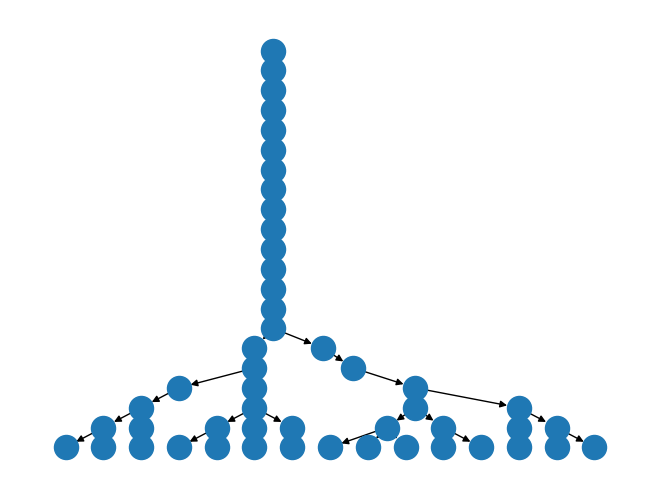

In [23]:
graph = create_graph_from_last_population(ev.population)
pos = graphviz_layout(graph, prog="dot")
nx.draw(graph, pos)

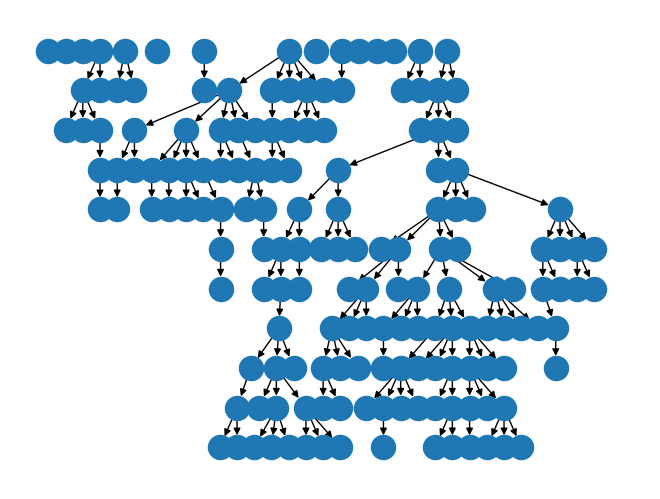

In [18]:
graph = create_graph_from_population_log(ev.population_log)
pos = graphviz_layout(graph, prog="dot")
nx.draw(graph, pos)

In [39]:
graph.nodes[28177755]

{'final': False,
 'coordinates': array([3.57484091, 0.65875779]),
 'fitness': 13.213449388223333}

In [24]:
import matplotlib.pyplot as plt

def plot_population(
        population: List[Point],
):
    try:
        assert len(population[0].coordinates) == 2
    except AssertionError:
        raise NotImplementedError('Plotting implemented only for 2D space')

    xs, ys = zip(*[p.coordinates for p in population])
    plt.scatter(xs, ys)
    # plt.show()

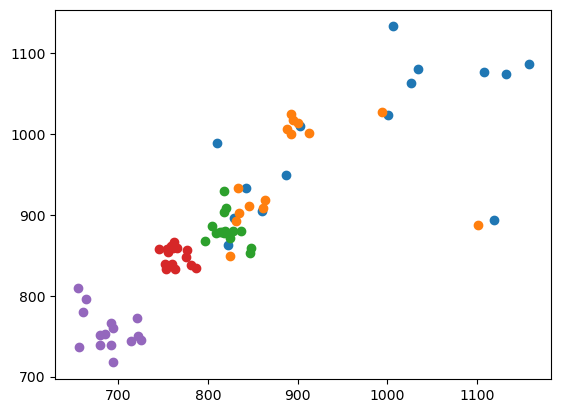

In [26]:
plot_population(ev.population_log[0])
plot_population(ev.population_log[1])
plot_population(ev.population_log[4])
plot_population(ev.population_log[10])
plot_population(ev.population_log[20])
# plot_population(ev.population_log[500])